In [1]:
### IMPORTS
from dateroll import ddh
import sys; # for localtesting
sys.path.insert(0,'/home/disent/github/ratecurve') 
from ratecurve import Curve
from ratecurve.equations import disc_factor

import matplotlib.pyplot as plt



In [2]:
### GENERATE DATA
def generate_curve_data(curve, tenors_to_interpolate, forward_tenor,verbose = False):
    anchor_date = curve.base
    dates_to_interpolate = [anchor_date +ddh(x) for x in tenors_to_interpolate]
    global spot_dates
    global spot_tenors
    global spot_x
    global spot_rates
    global spot_dfs
    
    global forward_dates
    global forward_tenors
    global forward_x
    global forward_rates
    global forward_dfs
    
    global par_tenors
    global par_dates
    global par_rates
    global par_dfs
    global par_x
    # Result variable instantiation
    spot_dates = []
    spot_tenors = []
    spot_x = []
    spot_rates = []
    spot_dfs = []
    
    forward_dates = []
    forward_tenors = []
    forward_x = []
    forward_rates = []
    forward_dfs = []

    report_string=''
    report_string+='-------------PAR DATA----------------\n'
    get_t = lambda b: (ddh(f't+{b}')-ddh('t')).yf("ALL","ACT/365")
    par_tenors =  [ddh(x).to_string() for x in curve_data.keys()]
    par_dates = [(anchor_date+ddh(x)).to_string() for x in par_tenors]
    par_rates = list(curve_data.values())
    par_dfs = [disc_factor(par_rates[i],get_t(par_tenors[i]),method="EXP") for i in range(len(par_tenors))]
    par_x = [((ddh(i) + anchor_date ) - anchor_date).just_days for i in curve_data.keys()]
    
    for i in range(len(par_dates)):
        report_string+=f'Tenor:{par_tenors[i]}, Par:{par_rates[i]}\n'
    report_string+='\n\n------------SPOT INTERPOLATION START------------\n'
    for i in range(len(dates_to_interpolate)):
        spot_rate = curve.spot(dates_to_interpolate[i])
        spot_df = curve(dates_to_interpolate[i])
        #x values
        spot_dates.append(dates_to_interpolate[i].to_string())
        spot_tenors.append((dates_to_interpolate[i]-ddh('t')).to_string())
        spot_x.append((dates_to_interpolate[i]-ddh('t')).just_days)
        #y values
        spot_rates.append(spot_rate)
        spot_dfs.append(spot_df)
        report_string +=f'Tenor:{tenors_to_interpolate[i]}, Spot:{spot_rate}\n'
    report_string +='------------SPOT INTERPOLATION FINISH-----------\n\n'
    report_string+=f'-----------{forward_tenor} FORWARD INTERPOLATION START --------------\n'
    for i in range(len(dates_to_interpolate)-1):
        fwd_date = ddh(dates_to_interpolate[i]) + ddh(forward_tenor)
        fwd_rate = curve.fwd(dates_to_interpolate[i],fwd_date)
        fwd_df = disc_factor(fwd_rate, get_t(tenors_to_interpolate[i]), method= "EXP")
        #y values
        forward_rates.append(fwd_rate)
        forward_dfs.append(fwd_df)
        #x vlaues
        forward_x.append((dates_to_interpolate[i]-ddh('t')).just_days) 
        forward_dates.append(dates_to_interpolate[i].to_string())
        forward_tenors.append((dates_to_interpolate[i]-ddh('t')).to_string())
        report_string+=f'Tenors:({tenors_to_interpolate[i]},{tenors_to_interpolate[i]}+{forward_tenor}), Rate:{fwd_rate}\n'
    report_string+=f'-----------{forward_tenor} FORWARD INTERPOLATION FINISH--------------'    

    if verbose:
        print(report_string)


In [3]:
# PLOTTING FUNCTION

def plot_curve(style='line', spacing = 'actual', y_axis = 'rate', x_axis = 'tenor', to_plot = ['par','spot','forward']):
    # Globals
    global forward_tenor
    
    global spot_dates
    global spot_tenors
    global spot_x
    global spot_rates
    global spot_dfs
    
    global forward_dates
    global forward_tenors
    global forward_x
    global forward_rates
    global forward_dfs
    
    global par_tenors
    global par_dates
    global par_rates
    global par_dfs
    global par_x

    # labeling maps
    tenor_x_map = {x:tenor for x,tenor in list(zip(par_x, par_tenors)) + list(zip(spot_x, spot_tenors)) + list(zip(forward_x, forward_tenors))}
    date_x_map = {x:date for x,date in list(zip(par_x, par_dates)) + list(zip(spot_x, spot_dates)) + list(zip(forward_x, forward_dates))}


    
    # y_vals
    par_y = par_rates if y_axis == 'rate' else par_dfs
    spot_y = spot_rates if y_axis == 'rate' else spot_dfs
    forward_y = forward_rates if y_axis == 'rate' else forward_dfs
    
    # x_vals
    #even spacing calculation
    # this scales x_vals so that all days are evenly spaced
    # 1. Find all unique x_vals (integer days since root date of curve class)
    # 2. Sort them and map unique values to their sorted index
    unique_xs = sorted(list(set((par_x + list(spot_x)) + list(forward_x))))
    x_map = {unique_xs[i]:i for i in range(len(unique_xs))}
    even_tenor_map = {x_map[i]:tenor_x_map[i] for i in unique_xs} 
    even_date_map = {x_map[i]:date_x_map[i] for i in unique_xs} 
    par_even_x = [x_map[val] for val in par_x]
    spot_even_x = [x_map[val] for val in spot_x]
    forward_even_x = [x_map[val] for val in forward_x]
    unique_even_xs = sorted(list(set((par_even_x + list(spot_even_x)) + list(forward_even_x))))
    
    
    # Plot generation    
    fig,ax = plt.subplots()
    
    if 'par' in to_plot:
        spaced_par_x = par_x if spacing == 'actual' else par_even_x
        spaced_par_x = par_x if spacing == 'actual' else par_even_x
        first_x = min(spaced_par_x)
        last_x = max(spaced_par_x)
        ax.axvline(x=first_x, color = 'gray', alpha = .5)
        ax.axvline(x=last_x,color = 'gray', alpha = .5)
        if style=='line':
            ax.plot(spaced_par_x, par_y, label="Par")
        else:
            ax.scatter(spaced_par_x, par_y, label="Par")
    if 'forward' in to_plot:
        spaced_forward_x = forward_x if spacing == 'actual' else forward_even_x
        if style=='line':
            ax.plot(spaced_forward_x, forward_y, label=f"{forward_tenor} Forward")
        elif style=='scatter':
            ax.scatter(spaced_forward_x, forward_y, label=f"{forward_tenor} Forward")
    if 'spot' in to_plot:
        spaced_spot_x = spot_x if spacing == 'actual' else spot_even_x
        if style=='line':
            ax.plot(spaced_spot_x, spot_y,label="Spot",)
        elif style=='scatter':
            ax.scatter(spaced_spot_x, spot_y,label="Spot",)
    
    labels = spot_tenors if x_axis == 'tenor' else spot_dates
    ###for actual spacing
    if spacing == 'actual':
        
        labels_subset = [labels[i] for i in range(len(labels)) if i in [0,9,11,12,13,14,15,16,17,18,19,20,21]]
        ticks_subset = [spot_x[i] for i in range(len(labels)) if i in [0,9,11,12,13,14,15,16,17,18,19,20,21] ]
        rotation = 60 if x_axis == 'date' else 90
        plt.xticks(ticks = ticks_subset,labels=labels_subset,rotation=rotation)
    else:
        labels_subset = [even_tenor_map[i] for i in unique_even_xs] if x_axis == 'tenor' else [even_date_map[i] for i in unique_even_xs]
        ticks_subset = unique_even_xs
        plt.xticks(ticks = ticks_subset,labels=labels_subset,rotation=90)
    
    x_label = f'{x_axis.capitalize()}'
    y_label = f'{y_axis.capitalize()}'
    title = f'Curve'
    #print(spaced_spot_x)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


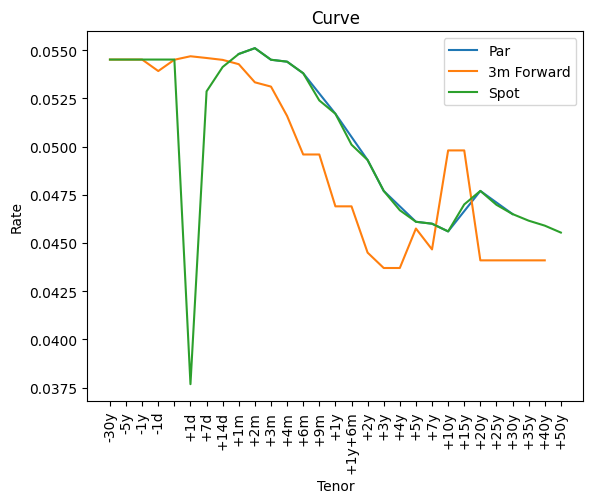

In [6]:
### CURVE GENERATION
# Curve Settings
curve_data =  {
    "1m":.0548,
     "2m":.0551,
     "3m":.0545,
     "4m":.0544,
     "6m":.0538,
     "1y":.0517,
     "2y":.0493,
     "3y":.0477,
     "5y":.0461,
     "7y":.0460,
     "10y":.0456,
     "20y":.0477,
     "30y":.0465
}
curve_settings = {
        'dc':"ACT/365", # only ACT/365 for now
        'cal':"ALL", # only ALL supported for now
        'method':"EXP", # 'EXP', 'YLD', 'LIN'
        'interp_on':"r*t", # 'ln(df)', 'r*t', or 'r'
        'interp_method':"linear", # see scipy for methods, 'linear', 'cubic' are common
        'extrap_method':'extrapolate', # 'flat' or 'extrapolate'
        'base':"t", # anchor date
}
curve = Curve(curve_data, **curve_settings)

### DATA GENERATION
# Data Settings
tenors_to_interpolate = ['-30y','-5y','-1y','-1d','0d','1d','1w','2w','1m','2m','3m','4m','6m','9m','1y','18m','2y','3y','4y','5y','7y','10y','15y','20y','25y','30y','35y','40y','50y']
# Forward distance for forward curve
forward_tenor = "3m"
generate_curve_data(curve, tenors_to_interpolate, forward_tenor)

# PLOT GENERATION
# Settings
plot_settings = {
'style':'line', # 'line' or 'scatter'
'spacing':'equal', #'actual' or 'equal'
'y_axis':'rate', # 'rate' or 'df'
'x_axis':'tenor', # 'date' or 'tenor'
'to_plot':['par','spot','forward'] # choices are 'par', 'spot' and 'forward'
}
plot_curve(**plot_settings)